In [1]:
#from support_fnc import data_gen,read_images,augment_brightness_camera_images,add_random_shadow,random_append_augment_images,img_resize
import csv
import cv2
import numpy as np
import random
from PIL import Image
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [44]:
lines=[]
def process_img(image):
    image=image[65:150,0:320,:]
    image = cv2.GaussianBlur(image, (3,3),0)
    image=cv2.resize(image,(200,66),interpolation=cv2.INTER_AREA) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image = image/255.0 - 0.5
    return image

def del_lines(lines):
    indices_del=[]
    lines1=[]
    for index,line in enumerate(lines[1:]):
        if abs(float(line[3]))<0.05:
            indices_del.append(index)
    len_ind_del=len(indices_del)
    indices_del=random.sample(indices_del,int(len_ind_del*0.9))
    #print(len_ind_del)
    for index,line in enumerate(lines[1:]):
        if index not in indices_del:
            lines1.append(lines[index])
    return lines1

def read_csv(lines=[]):
    with open('../CarND-Behavioral-Cloning-P3/Udacity_data/data/driving_log.csv') as csvfile:
        reader=csv.reader(csvfile)
        header = next(reader)
        for line in reader:
            lines.append(line)
    with open('../CarND-Behavioral-Cloning-P3/recorded_data_add/driving_log.csv') as csvfile:
        reader=csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    with open('../CarND-Behavioral-Cloning-P3/recorded_data_add_add/driving_log.csv') as csvfile:
        reader=csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    #print(len(lines))
    lines=del_lines(lines)
    #print(len(lines))
    return lines

def comp_side_cam(line,i):
    measurement=0
    if (i==0): 
        measurement = float(line[3]) 
    elif (i==1): #left camera
        measurement = float(line[3]) + 0.2
    elif (i==2): #right camera
        measurement = float(line[3]) - 0.2
    return measurement

def read_images(sample_dt):
    images=[]
    measurements=[]
    for line in sample_dt:
        for i in range(3):
            source_path=line[i]
            #print('source_path',source_path)
            #print(if ("recorded_data\\IMG") in source_path)
            if 'recorded data\IMG' in source_path:
                filename=(source_path.split("\\"))[8]
                current_path='../CarND-Behavioral-Cloning-P3/recorded_data/IMG/'+filename
                image=cv2.imread(current_path)
                image=process_img(image)
                images.append(image)
                measurement=comp_side_cam(line,i)
                measurements.append(measurement)
            elif 'recorded_data_add\IMG' in source_path:
                filename=(source_path.split("\\"))[8]
                current_path='../CarND-Behavioral-Cloning-P3/recorded_data_add/IMG/'+filename
                image=cv2.imread(current_path)
                image=process_img(image)
                images.append(image)
                measurement=comp_side_cam(line,i)
                measurements.append(measurement)
            elif 'recorded_data_add_add\IMG' in source_path:
                filename=(source_path.split("\\"))[-1]
                current_path='../CarND-Behavioral-Cloning-P3/recorded_data_add_add/IMG/'+filename
                image=cv2.imread(current_path)
                image=process_img(image)
                images.append(image)
                measurement=comp_side_cam(line,i)
                measurements.append(measurement)
            else:
                filename=source_path.split('/')[-1]
                current_path='../CarND-Behavioral-Cloning-P3/Udacity_data/data/IMG/'+filename
                image=cv2.imread(current_path)
                image=process_img(image)
                images.append(image)
                measurement=comp_side_cam(line,i)
                measurements.append(measurement)
                    #image1 = Image.open(current_path)
    #image_array=image1.crop((0,65,320,150))
    #image_array=image_array.resize((200,66))
    #plt.imshow(np.asarray(image_array))
    images.extend([np.fliplr(img) for img in images])
    measurements.extend([-angle for angle in measurements])
    ind_del=[]
    co=0
    #print('len of meas',len(measurements))
    for ind,val in enumerate(measurements):
        if float(val)<0.03   and co <500 and float(val)>0.0:
            del measurements[ind]
            del images[ind]
            co=co+1
    #print('len of meas',len(measurements))
    #plt.figure()
    #plt.hist(measurements,30)
    #plt.show()
    
    return images,measurements



def augment_brightness_camera_images(image):
    image = np.uint8(image)
    image = cv2.cvtColor(image,cv2.COLOR_YUV2BGR)
    image1 = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2BGR)
    image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2YUV)
    return image1


def add_random_shadow(image):
    top_y = 200*np.random.uniform()
    top_x = 0
    bot_x = 66
    bot_y = 200*np.random.uniform()
    image = np.uint8(image)
    image = cv2.cvtColor(image,cv2.COLOR_YUV2BGR)
    image_hls = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = 0.9
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2BGR)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2YUV)
    return image

def random_append_augment_images(images,measurements):
    rand_arr=random.sample(list(range(1,len(measurements))),int(len(measurements)/3))
    rand_arr_1=random.sample(list(range(1,len(measurements))),int(len(measurements)/3))
    for index,value in enumerate(measurements):
        if index in rand_arr:
            images.append(augment_brightness_camera_images(images[index]))
            measurements.append(measurements[index])
        if index in rand_arr_1:
            images.append(add_random_shadow(images[index]))
            measurements.append(measurements[index])
    return images, measurements


In [45]:
def data_gen(lines, batch_size=30):
    while True:
        sample_dt=random.sample(lines[2:],int(batch_size/2))
        images,measurements=read_images(sample_dt)
        #images,measurements=random_append_augment_images(images,measurements)
        
        images=np.asarray(images)
        measurements=np.asarray(measurements)
        ind = np.random.choice(images.shape[0], batch_size, replace=False)
        images=images[ind,:,:,:]
        measurements=measurements[ind]
        X=images
        y=measurements
        
        yield X,y

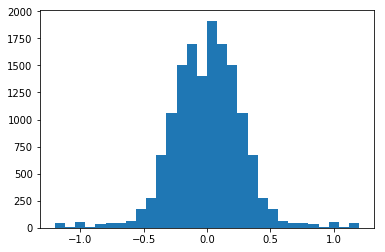

In [46]:
lines=read_csv()
#%matplotlib inline
def display_im(X,y):
    index=random.randint(0,len(X))
    image=X[index].squeeze()
    plt.figure(figsize=(4,4))
    #plt.imshow(image)
    plt.imshow(cv2.cvtColor(np.uint8(image), cv2.COLOR_BGR2RGB))
    print('Output Label for the input',index,' is :', y[index])

gen_example=data_gen(lines,5000)

images,measurements=next(gen_example)
#plt.figure()
#plt.hist(measurements,30)
#plt.show()


#images,measurements=gen_example
#images1=np.reshape(images,(-1,image.shape[0],image.shape[1],3))
#measurements1=np.reshape(measurements,(-1))

#display_im(images1,measurements1)
#print(images.shape)
image=images[5]
#image1= cv2.cvtColor(np.uint8(image),cv2.COLOR_YUV2BGR)
#image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2HLS)
#plt.imshow(image)
#image2=add_random_shadow(image)
#plt.imshow(image2)
#print(image2[3,:,:])


In [12]:
#model = load_model('model.h5')

from keras.models import Sequential
from keras.layers import Flatten,Dense, Lambda
# There was a problem with original Keras progress bar due to which Notebook used to hang.
# Changing the progress bar with another version of it so as to get the code working in Notebook. Look at model.fit command on how its used
#from keras_tqdm import TQDMNotebookCallback 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Activation, Cropping2D, ELU
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# NVIDIA Model
input_shape=(image.shape[0],image.shape[1],3)
model=Sequential()
#model.add(Lambda(lambda x:x/255.0-0.50,input_shape=input_shape))
model.add(Conv2D(3,1,1,subsample=(1,1),border_mode="valid",init='he_normal',input_shape=input_shape))
model.add(ELU())
model.add(Conv2D(24,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(36,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Dropout(.4))
model.add(Conv2D(48,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(64,3,3,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(64,3,3,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(Dropout(.3))
model.add(ELU())
model.add(Flatten())
model.add(Dense(1164,init='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(.2))
model.add(Dense(100,init='he_normal'))
model.add(ELU())
model.add(Dense(50,init='he_normal'))
model.add(ELU())
model.add(Dense(10,init='he_normal'))
model.add(ELU())
model.add(Dense(1,init='he_normal'))

model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])



batch_size=32
epochs=6
gen_train=data_gen(lines,30)
gen_valid=data_gen(lines,30)


model.fit_generator(gen_train, samples_per_epoch=25000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=2500, max_q_size=25, nb_worker=4, pickle_safe=True)
model.save('model_add.h5')

NameError: name 'image' is not defined